<a href="https://colab.research.google.com/github/marcelounb/BB/blob/master/ia_mobile_TF_many_categories_final3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
path = "/content/fulldataset.xlsx"

In [4]:
dataset = pd.read_excel(path, sheet_name=0, header=0, dtype={'score': np.int32})

dataset[dataset.columns[3]] = dataset[dataset.columns[3]].fillna('não se aplica')  # retirando os valores nulos

responsavel       = dataset[dataset.columns[0]].tolist()   # Responsável
natureza          = dataset[dataset.columns[1]].tolist()   # Natureza
classificacao     = dataset[dataset.columns[2]].tolist()   # Classificação
produtos_servicos = dataset[dataset.columns[3]].tolist()   # Produtos/Serviços
detalhamento      = dataset[dataset.columns[4]].tolist()   # Detalhamento
review            = dataset[dataset.columns[15]].tolist()  # review
score             = dataset[dataset.columns[16]].tolist()  # score

In [5]:
dataset.columns

Index(['Responsável', 'Natureza', 'Classificação', 'Produtos/Serviços',
       'Detalhamento', 'Descrição do Problema', 'Produtos/Serviços 2',
       'Detalhamento 2', 'Descrição do Problema 2', 'Produtos/Serviços 3',
       'Detalhamento 3', 'Descrição do Problema 3', 'id', 'userName',
       'userImage', 'review', 'score', 'thumbsUpCount', 'appVersion', 'date',
       'reply', 'replyDate'],
      dtype='object')

# Reduzindo o texto (retirando artigos, pontuacao e conjuncao 'e')

In [6]:
def reduzir_texto(frases):
  frase = ''
  for item in frases.lower().split():
    if item not in ['a', 'o', 'as', 'os', 'da', 'do', 'das', 'dos', 'e']:  # retira os artigos e conjuncao 'e'
      if item[-1] in ['.', ',', '!', ';' ]:
        frase +=str(item[0:-1])+' '  # retira pontuacao
      else:
        frase +=str(item)+' '

  return frase[:-1]

In [7]:
review_reduzida = []
for item in review:
  review_reduzida.append(reduzir_texto(item))
print(review[0:5])
print(review_reduzida[0:5])

['Excelente', 'Muito bom', 'Não estou conseguindo fazer um cartão de crédito para mim Eu só quero Aff já tentei várias vezes fazer o cartão quando eu fui fazer mandou esperar treis dias aí quando eu fui abri o aplicativo para ver se foi aprovado , Táva mandando fazer tudo dinovo', 'Por mais que eu tente não consigo desbloquear o app para transferências', 'Bom aplicativo eu gosto']
['excelente', 'muito bom', 'não estou conseguindo fazer um cartão de crédito para mim eu só quero aff já tentei várias vezes fazer cartão quando eu fui fazer mandou esperar treis dias aí quando eu fui abri aplicativo para ver se foi aprovado  táva mandando fazer tudo dinovo', 'por mais que eu tente não consigo desbloquear app para transferências', 'bom aplicativo eu gosto']


# Separando as bases de treinamento e de testes

In [8]:
# Separate out the sentences and labels into training and test sets
training_size = int(len(review) * 0.8)

training_sentences = review[0:training_size]
testing_sentences = review[training_size:]
training_labels = classificacao[0:training_size]  # Aqui !!!!       # Aqui !!!
testing_labels = classificacao[training_size:]  # Aqui !!!!       # Aqui !!!
training_score = score[0:training_size]
testing_score = score[training_size:]

In [9]:
def acrescentando_dimensionalidade(listagem):
  lista2 = []
  for item in listagem:
    lista3 = []
    lista3.append(item)
    lista2.append(lista3)
  return lista2

In [10]:
print(training_score[0:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [11]:
training_score = acrescentando_dimensionalidade(training_score)
testing_score = acrescentando_dimensionalidade(testing_score)

In [12]:
print(training_score[0:10])

[[1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]


In [13]:
# Tokenizing classificacao
tokenizer = Tokenizer(split='@', filters='@')  # Não categoriza novas palavras por causa de espaço ou caracteres especiais
tokenizer.fit_on_texts(classificacao)  # Aqui !!!!       # Aqui !!!
word_index = tokenizer.word_index
print(word_index)
prediction_classes = word_index
reversed_prediction_classes = {value : key[0].upper() + key[1:] for (key, value) in prediction_classes.items()}
print(reversed_prediction_classes)

{'elogio': 1, 'reclamação': 2, 'crítica': 3, 'neutra': 4, 'dúvida': 5, 'sugestão': 6, 'resposta': 7, 'solicitação': 8}
{1: 'Elogio', 2: 'Reclamação', 3: 'Crítica', 4: 'Neutra', 5: 'Dúvida', 6: 'Sugestão', 7: 'Resposta', 8: 'Solicitação'}


In [14]:
len(word_index)
tamanho_classes = len(word_index)+1

In [15]:
def transforming_labels(lista):
  temp = []
  for item in lista:
    temp.append(word_index.get(item.lower()))
  return temp

In [16]:
training_labels[0:20]

['Elogio',
 'Elogio',
 'Reclamação',
 'Reclamação',
 'Elogio',
 'Reclamação',
 'Reclamação',
 'Reclamação',
 'Reclamação',
 'Reclamação',
 'Crítica',
 'Elogio',
 'Reclamação',
 'Reclamação',
 'Reclamação',
 'Crítica',
 'Reclamação',
 'Reclamação',
 'Elogio',
 'Reclamação']

In [17]:
training_labels = transforming_labels(training_labels)
testing_labels = transforming_labels(testing_labels)
training_labels[0:20]

[1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 3, 2, 2, 1, 2]

In [18]:
# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)
training_labels_final

array([1, 1, 2, ..., 1, 1, 1])

In [19]:
print(training_sentences[0:5])
print(training_labels[0:20], testing_labels[0:20])

['Excelente', 'Muito bom', 'Não estou conseguindo fazer um cartão de crédito para mim Eu só quero Aff já tentei várias vezes fazer o cartão quando eu fui fazer mandou esperar treis dias aí quando eu fui abri o aplicativo para ver se foi aprovado , Táva mandando fazer tudo dinovo', 'Por mais que eu tente não consigo desbloquear o app para transferências', 'Bom aplicativo eu gosto']
[1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 3, 2, 2, 1, 2] [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2]


# Tokenize the dataset
Tokenize the dataset, including padding and OOV

In [20]:
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)  #review de treinamento com padding

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)  #review de treinamento com padding

In [21]:
print(padded.shape, testing_padded.shape)

(66064, 100) (16516, 100)


In [22]:
print(padded[:2])
print(training_score[:2])

[[13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]
[[1], [1]]


In [23]:
print(len(training_score), len(testing_score))

66064 16516


In [24]:
type(training_score)

list

In [25]:
training_score = np.asarray(training_score)
testing_score = np.asarray(testing_score)
print(type(training_score), type(testing_score))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [26]:
padded2 = np.append(training_score, padded, axis=1)

In [27]:
testing_padded2 = np.append(testing_score, testing_padded, axis=1)

# Review a Sequence
Let's quickly take a look at one of the padded sequences to ensure everything above worked appropriately.

In [28]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, 'x') for i in text])

print(decode_review(padded[0]))
print(training_sentences[0])

excelente x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x
Excelente


# Train a Basic Sentiment Model with Embeddings

In [29]:
max_length +=1  # Somando 1 do Score

In [30]:
# Build a basic sentiment network
# Note the embedding layer is first, 
# and the output is only 1 node as it is either 0 or 1 (negative or positive)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(50, activation='relu', input_shape=(100,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(tamanho_classes, activation='softmax')
])


# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'] )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 101, 16)           16000     
_________________________________________________________________
flatten (Flatten)            (None, 1616)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               161700    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 4

In [31]:
num_epochs = 3
hist = model.fit(padded2, training_labels_final, epochs=num_epochs, validation_data=(testing_padded2, testing_labels_final))

Epoch 1/3
2065/2065 [==============================] - 7s 3ms/step - loss: 0.2128 - accuracy: 0.9405 - val_loss: 0.1641 - val_accuracy: 0.9530
Epoch 2/3
2065/2065 [==============================] - 7s 3ms/step - loss: 0.1528 - accuracy: 0.9522 - val_loss: 0.1591 - val_accuracy: 0.9528
Epoch 3/3
2065/2065 [==============================] - 7s 3ms/step - loss: 0.1267 - accuracy: 0.9586 - val_loss: 0.1693 - val_accuracy: 0.9497


In [32]:
scores = model.evaluate(testing_padded2, testing_labels_final, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print(hist.history.keys())

Baseline Error: 5.03%
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


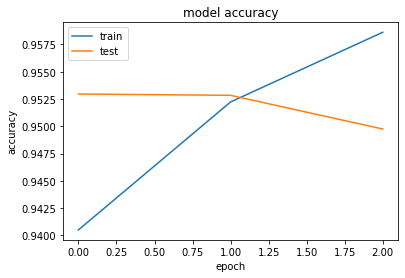

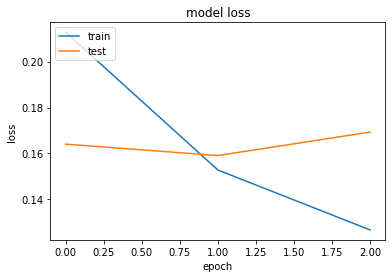

In [33]:
plt.plot(hist.history[ 'accuracy' ])
plt.plot(hist.history[ 'val_accuracy' ])
plt.title( 'model accuracy' )
plt.ylabel( 'accuracy')
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'test' ], loc= 'upper left' )
plt.show()
# summarize history for loss
plt.plot(hist.history[ 'loss' ])
plt.plot(hist.history[ 'val_loss' ])
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'test' ], loc= 'upper left' )
plt.show()

# Novas Predições:

In [34]:
path = "/content/novoarquivo.xlsx"

In [35]:
dataset = pd.read_excel(path, sheet_name=0, header=0, dtype={'score': np.int32})

responsavel       = dataset[dataset.columns[0]].tolist()   # Responsável
natureza          = dataset[dataset.columns[1]].tolist()   # Natureza
classificacao     = dataset[dataset.columns[2]].tolist()   # Classificação
produtos_servicos = dataset[dataset.columns[3]].tolist()   # Produtos/Serviços
detalhamento      = dataset[dataset.columns[4]].tolist()   # Detalhamento
review            = dataset[dataset.columns[15]].tolist()  # review
score             = dataset[dataset.columns[16]].tolist()  # score

In [36]:
# Use the model to predict a review   
new_reviews = review

print(new_reviews) 

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(new_reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

print('\nHOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!\n')              

classes = model.predict(fakes_padded)

print(new_reviews[17])
print(classes[15:17])

['muito útil pra mim.', '👍', 'O aplicativo tem muito a melhor, pois as vezes acontece uns bugs, trava.', 'regular', 'ótimo app', 'O melhor App, melhor banco!', 'gostei muito', 'muito bom gostei.', 'prático', 'excelente!', 'o app é bom', 'eletrodo 051 poupança orurcard 00', 'Melhor App do setor bancário. Intuitivo, leve e sempre funciona. Sou fã', 'bom', 'Gostei do APP, bem funcional e fácil de utilizar.', 'muita útil', 'Excelente.', 'o banco com muita competência,e principalmente quero elogiar funcionário Alex sempre que eu vou na minha agência me trata super bem', 'otimo', 'parabenizo ao banco do brasil pela assistência aos seus clientes. e o aplicativo e ótimo', 'simplesmente maravilhoso.', 'Excelente apkicativo', 'muito bom .. facilita demais', 'Aplicativo sem nenhuma crítica a fazer. Só elogio.', 'recomendo', 'muito bom', 'As restrições de valores mas transações praticamente inviabiliza agilidade e efetividade no dia a dia. Vou reduzir o movimento nesta conta e movimentar em outros

In [37]:
classes_list = classes.tolist()
for contagem in range(15):
  print(contagem, classes_list[contagem].index(np.max(classes[contagem], axis=0, keepdims=True)))

0 1
1 1
2 2
3 3
4 3
5 1
6 1
7 1
8 1
9 1
10 1
11 2
12 1
13 4
14 1


In [38]:
print(reversed_prediction_classes)
print(reversed_prediction_classes[2])

{1: 'Elogio', 2: 'Reclamação', 3: 'Crítica', 4: 'Neutra', 5: 'Dúvida', 6: 'Sugestão', 7: 'Resposta', 8: 'Solicitação'}
Reclamação


In [39]:
lista_predicao = []
for item in classes_list:
  lista_predicao.append(reversed_prediction_classes[item.index(max(item))])
lista_predicao[10:20]

['Elogio',
 'Reclamação',
 'Elogio',
 'Neutra',
 'Elogio',
 'Elogio',
 'Elogio',
 'Elogio',
 'Neutra',
 'Elogio']

In [40]:
dataset[dataset.columns[2]] = lista_predicao  # Aqui !!!!       # Aqui !!!
dataset.head(3)

,Responsável,Natureza,Classificação,Produtos/Serviços,Detalhamento,Descrição do Problema,Produtos/Serviços 2,Detalhamento 2,Descrição do Problema 2,Produtos/Serviços 3,Detalhamento 3,Descrição do Problema 3,id,userName,userImage,review,score,thumbsUpCount,appVersion,date,reply,replyDate
0,Automático,Opinião,Elogio,Aplicativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gp:AOqpTOGg0Ev4vB_osA6Vwgrw3LwwPgWNswzhCMkxbIt...,Ketlley Rose,https://play-lh.googleusercontent.com/a-/AOh14...,muito útil pra mim.,4,0,7.29.2.0,2020-10-26 09:28:38,NaN,NaT
1,Rossato,Opinião,Elogio,Aplicativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gp:AOqpTOGJpbBxSAVeEexyJCkSou2OFbdAUhTK4O5KCsD...,Gabriel Pinheiro,https://play-lh.googleusercontent.com/-pwSaK9q...,👍,5,0,7.29.2.0,2020-10-26 09:25:37,NaN,NaT
2,Automático,Técnica,Reclamação,Aplicativo,Disponibilidade/Estabilidade,Travamento,NaN,NaN,NaN,NaN,NaN,NaN,gp:AOqpTOHBKSLCpLKrgAY04-Vd2pX5b-xyDpQTxuV0XBd...,jose lucas,https://play-lh.googleusercontent.com/a-/AOh14...,"O aplicativo tem muito a melhor, pois as vezes...",3,0,7.29.2.0,2020-10-26 09:22:47,"Oi! Li seu comentário, mas não consegui entend...",2020-10-26 08:19:19


# Salvando o arquivo em Excel

In [41]:
writer = pd.ExcelWriter("predicao_gerada.xlsx")
dataset.to_excel(writer, index=False)
writer.save()